In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
from sklearn.preprocessing import MinMaxScaler
import random
import tensorflow as tf

# Prepare training and testing data

In [2]:
with open('heart.csv') as f:
    temp = np.loadtxt(f, delimiter=',', skiprows=1)

X = temp[:,:-1]
y = temp[:,-1]
X = MinMaxScaler().fit_transform(X)
y = np.tensor([-1 if i == 0 else 1 for i in y])

num_data = len(y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = X[index[:num_train]]
Y_train = y[index[:num_train]]
feats_val = X[index[num_train:]]
Y_val = y[index[num_train:]]

In [4]:
X.shape

(303, 13)

# define varational circuit

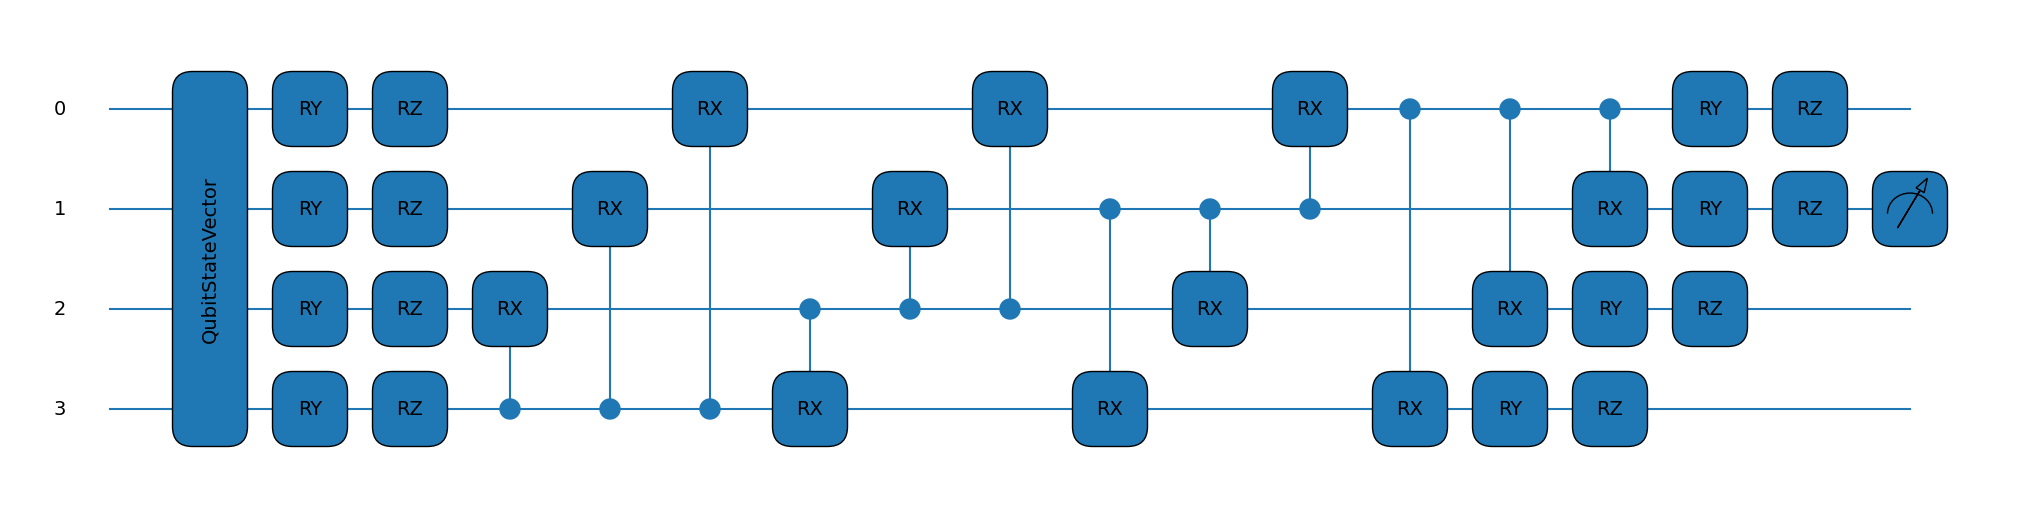

In [11]:
num_wires = 4
dev = qml.device("default.qubit", wires=num_wires)

@qml.qnode(dev, diff_method="backprop")
def circuit(feature_vector,weights=None):
    qml.AmplitudeEmbedding(features=feature_vector, wires=range(num_wires), pad_with=0,normalize=True)
    qml.RY(weights[0], wires=0)
    qml.RZ(weights[1], wires=0)
    qml.RY(weights[2], wires=1)
    qml.RZ(weights[3], wires=1)
    qml.RY(weights[4], wires=2)
    qml.RZ(weights[5], wires=2)
    qml.RY(weights[6], wires=3)
    qml.RZ(weights[7], wires=3)

    qml.CRX(weights[8],wires=[3,2])
    qml.CRX(weights[9],wires=[3,1])
    qml.CRX(weights[10],wires=[3,0])

    qml.CRX(weights[11],wires=[2,3])
    qml.CRX(weights[12],wires=[2,1])
    qml.CRX(weights[13],wires=[2,0])

    qml.CRX(weights[14],wires=[1,3])
    qml.CRX(weights[15],wires=[1,2])
    qml.CRX(weights[16],wires=[1,0])

    qml.CRX(weights[17],wires=[0,3])
    qml.CRX(weights[18],wires=[0,2])
    qml.CRX(weights[19],wires=[0,1])

    qml.RY(weights[20], wires=0)
    qml.RZ(weights[21], wires=0)
    qml.RY(weights[22], wires=1)
    qml.RZ(weights[23], wires=1)
    qml.RY(weights[24], wires=2)
    qml.RZ(weights[25], wires=2)
    qml.RY(weights[26], wires=3)
    qml.RZ(weights[27], wires=3)
    return qml.expval(qml.PauliZ(wires=1))
weights = np.array([0.59, 1.48, 0.02,-1.57, 0.60, 1.49, 0.47, 0.72, -1.15, 3.39, 0.25, 0.19, -0.47, 2.36, 0.36, -0.69, -0.16, 0.51, 0.94, 1.57, 0.29, 0.85, -0.00, 0.34, 0.34, 0.89, 0.85, 0.72], requires_grad=True)
# weights = np.random.random(size=[28], requires_grad=True)
bias = np.array(0.05, requires_grad=True)
# bias = np.array(0.0, requires_grad=True)
fig, ax = qml.draw_mpl(circuit, expansion_strategy="device")(feats_train[0],weights)

In [9]:
def variational_classifier(weights, bias,feature_vector):
    return circuit( feature_vector,weights)+bias

def cost(weights, bias, features, labels):
    predictions = [variational_classifier(weights, bias,f) for f in features]
    loss = 0
    for l, p in zip(labels, predictions):
        loss +=  (l - p) ** 2
    return loss/ len(labels)

def accuracy(labels, predictions):
    success = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 0.5:
            success += 1
    return success/ len(labels)

In [13]:
opt = NesterovMomentumOptimizer(stepsize=0.02)

def mini_batch_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        j = tf.constant(indices[i:min(i + batch_size, num_examples)])
        yield tf.gather(features, j), tf.gather(labels, j)

num_epochs = 100
batch_size = 20
for epoch in range(num_epochs):
    for feats_train_batch, Y_train_batch in mini_batch_iter(batch_size, feats_train, Y_train):
        feats_train_batch = feats_train_batch.numpy()
        Y_train_batch = Y_train_batch.numpy()
        # Update the weights by one optimizer step
        weights, bias, _, _ = opt.step(cost, weights, bias,feats_train_batch , Y_train_batch)
    
    # Compute predictions on train and validation set
    predictions_train = [np.sign(variational_classifier(weights, bias, f)) for f in feats_train]
    predictions_val = [np.sign(variational_classifier(weights, bias, f)) for f in feats_val]
    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)
    print(
        "Epoch: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
        "".format(epoch + 1, cost(weights, bias, X, y), acc_train, acc_val)+str([ float("{:.5f}".format(elem)) for elem in weights.flatten().tolist() ])+str( float("{:.5f}".format(bias)))
    )

Epoch:     1 | Cost: 0.5901936 | Acc train: 0.8105727 | Acc validation: 0.8157895 [0.59565, 1.48174, 0.02056, -1.57096, 0.59901, 1.49266, 0.47375, 0.72517, -1.15484, 3.39125, 0.24218, 0.19398, -0.47685, 2.35937, 0.35963, -0.70717, -0.16602, 0.51, 0.94, 1.56389, 0.29, 0.85, 0.00176, 0.34, 0.34, 0.89, 0.85, 0.72]0.04565
Epoch:     2 | Cost: 0.5902396 | Acc train: 0.8149780 | Acc validation: 0.8157895 [0.57863, 1.47856, -0.0104, -1.57274, 0.58789, 1.49271, 0.469, 0.73212, -1.1521, 3.37206, 0.26029, 0.2006, -0.48138, 2.37799, 0.36566, -0.69698, -0.16649, 0.51, 0.94, 1.56824, 0.29, 0.85, -0.00052, 0.34, 0.34, 0.89, 0.85, 0.72]0.03628
Epoch:     3 | Cost: 0.5921489 | Acc train: 0.8017621 | Acc validation: 0.8157895 [0.57825, 1.47684, 0.00685, -1.57331, 0.57835, 1.4937, 0.48164, 0.73844, -1.1509, 3.37707, 0.25321, 0.20647, -0.48561, 2.37438, 0.3673, -0.70919, -0.17298, 0.51, 0.94, 1.57864, 0.29, 0.85, -0.00166, 0.34, 0.34, 0.89, 0.85, 0.72]0.07644
Epoch:     4 | Cost: 0.5907641 | Acc train: 0

KeyboardInterrupt: 

In [ ]:
 ['0.90', '-0.45', '0.07', '-1.14', '1.46', '-0.21', '1.07', '-0.52', '1.84', '3.76', '0.58', '-0.42', '-0.86', '-1.10', '2.76', '1.56', '-0.07', '0.33', '0.20', '-0.92', '0.45', '0.49', '0.60', '0.12', '0.44', '0.54', '0.22', '0.31']0.06